In [5]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer

from sksurv.datasets import load_whas500

#importing models
from sklearn.linear_model import LogisticRegression
from sksurv.linear_model import CoxPHSurvivalAnalysis
import xgboost as xgb


In [6]:
#importing test data
X_raw,y_raw = load_whas500()

In [27]:
y = np.array([int(x[0]) for x in y_raw])

In [28]:
#Scaler pipeline
numerical_columns = X_raw.columns[X_raw.dtypes == "float64"]

preprocessor = ColumnTransformer(transformers=[
    ("scaler",StandardScaler(),numerical_columns)
], remainder= "passthrough")

X = preprocessor.fit_transform(X_raw)
col_names = [x.split("__",1)[-1] for x in preprocessor.get_feature_names_out()]
X = pd.DataFrame(X,columns = col_names)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# calibration plot

In [39]:
# # Calibration plot class

# %%
class Calibration_plot():
    def __init__(self,X,y,y_pred):
        self.X = X
        self.y = y
        #?Could have y_pred as a list of predictions eventually
        self.y_pred = y_pred


    #method to work out calibration df
    def calculate(self):
        deciles = np.percentile(y_pred)


    def add_model(self,new_model):
        self.y_pred_list = self.y_pred_list.append(new_model)


# Log regression

In [31]:
# %%
# Fitting the logistic regression model (data has been prescaled and ohe)

logreg = LogisticRegression()

logreg_pipe = Pipeline([
    ("model", logreg)
])

logreg_pipe.get_params().keys()

#simple parameters
params = {
    "model__penalty": ["l2","none"]
}

logreg_grid = GridSearchCV(estimator = logreg_pipe,
                param_grid = params,
                cv = 4,
                scoring = "accuracy")


# %%
logreg_grid.fit(X_train,y_train)

pd.DataFrame(logreg_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006994,0.000699,0.001126,0.000548,l2,{'model__penalty': 'l2'},0.74,0.79,0.77,0.80,0.7750,0.022913,1
1,0.006655,0.000412,0.001500,0.000513,none,{'model__penalty': 'none'},0.75,0.79,0.74,0.79,0.7675,0.022776,2


In [32]:
# %%
logreg_model = logreg_grid.best_estimator_.named_steps["model"]

# logreg_model.coef_
# #can think about coding up a feature name tracker transformer but we will leave that alone for now
# X_train.columns
logreg_coefs = [x for x in zip(X_train.columns,logreg_model.coef_[0,:])]

logreg_pred = logreg_model.predict_proba(X_train)[:,1]

# %%
logreg_coefs

# %%
print(len(logreg_pred))
print(len(y_train))



# %%
X_train.iloc[np.argsort(logreg_pred)[-10:],:]

# %%
#checking highest risk patients
X.iloc[X_train.iloc[np.argsort(logreg_pred)[-10:],:].index]

400
400


,age,bmi,diasbp,hr,los,sysbp,afb,av3,chf,cvd,gender,miord,mitype,sho
473,1.392143,-0.592958,-0.895105,1.145118,0.187709,-0.548748,1,0,1,1,1,0,1,0
98,0.286939,-1.13487,-0.29112,2.970042,0.187709,-1.075674,0,0,1,0,0,0,0,0
432,1.323068,-1.482656,-1.127406,0.126556,-0.661654,-0.145804,0,1,1,1,0,1,0,0
462,1.530294,-0.743862,-0.848644,0.720717,-0.661654,-0.145804,0,0,1,0,1,1,0,0
492,1.599369,-0.534642,-0.848644,0.975358,-0.236972,0.412119,0,0,1,1,0,1,0,0
250,2.221047,-0.803639,-0.848644,0.084116,-0.661654,-0.827709,0,0,1,0,0,0,0,0
285,1.253993,-0.986383,-2.242454,2.24856,0.40005,-2.160523,0,0,0,0,0,1,0,0
401,1.184918,-0.660772,-1.545549,1.696839,-0.236972,-1.261648,0,0,1,1,1,1,0,0
217,1.323068,-1.31246,-0.755724,1.824159,-0.449313,-1.261648,1,0,1,1,0,0,0,0
54,1.184918,-1.415317,-1.034486,1.314879,-0.661654,-0.858704,0,0,1,1,1,0,1,1


In [35]:

# %%
#y_pred = logreg_pred
deciles = np.percentile(logreg_pred,np.arange(10,101,10))
deciles = np.insert(deciles,0,0)
deciles
data_deciles = pd.cut(logreg_pred, bins = deciles)
np.mean(logreg_pred[data_deciles.codes == 2])


0.14448880277564796

In [36]:
# %%
temp_df = pd.DataFrame(index = range(10),columns = range(2))
for n in range(0,10):
    #observed risk
    obs_risk = np.mean(y_train[data_deciles.codes == n])
    temp_df[0][n] = obs_risk

    #predicted risk in group n
    pred_risk = np.mean(logreg_pred[data_deciles.codes == n])
    temp_df[1][n] = pred_risk

    
temp_df.columns = ["obs_risk","pred_risk"]
temp_df


,obs_risk,pred_risk
0,0.025,0.025934
1,0.075,0.070384
2,0.075,0.144489
3,0.25,0.236517
4,0.225,0.337937
5,0.575,0.437431
6,0.55,0.576209
7,0.75,0.695751
8,0.9,0.836796
9,0.875,0.938553


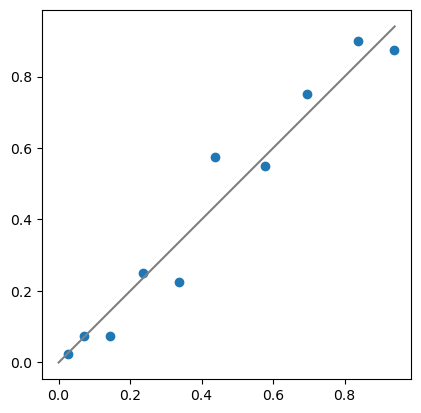

In [37]:
# %%
np.ceil(temp_df.max().max()/0.05)*0.05

# %%

ax = plt.gca()
ax.set_aspect("equal")
plt.scatter(temp_df["pred_risk"],temp_df["obs_risk"])
#identity function
temp_x = np.arange(0,np.ceil(temp_df.max().max()/0.05)*0.05,0.01)
temp_y = temp_x
plt.plot(temp_x,temp_y,color = "grey")

# coxph

In [43]:

# %%
#creating the response variable

# # len(y_train)
# # len(total_fu.iloc[X_train.index]["total_fu"])
# y_surv_temp = 

# # Create an empty NumPy array with dtype 'object'
# y_surv_train = np.empty(len(y_surv_temp), dtype=object)

# # Assign tuples to the array
# for i, item in enumerate(y_surv_temp):
#     y_surv_train[i] = item

# y_surv_train = np.array([(bool(i[0]),i[1]) for i in zip(y_train[:],total_fu.iloc[X_train.index]["total_fu"])],
#                              dtype=[('event', bool), ('time', np.float64)])

# y_surv_train

# # %%
#fitting the cox model
coxph_model = CoxPHSurvivalAnalysis()

coxph_model.fit(X_train,y_raw[X_train.index])


coxph_coefs = [x for x in zip(X_train.columns,coxph_model.coef_[:])]
coxph_coefs



[('age', 0.8106086264455138),
 ('bmi', -0.15329363895014123),
 ('diasbp', -0.35698427905997876),
 ('hr', 0.37573938432021886),
 ('los', -0.023641573336589596),
 ('sysbp', 0.041287964498526314),
 ('afb', 0.1078295541236525),
 ('av3', 0.3670349849632404),
 ('chf', 0.7181151155179131),
 ('cvd', -0.17560178691909215),
 ('gender', -0.2943849814814609),
 ('miord', 0.009939794963756065),
 ('mitype', -0.14896669387054107),
 ('sho', 1.0093568905907124)]

In [44]:
coxph_pred = coxph_model.predict(X_train)

In [45]:
coxph_pred

array([ 0.46648256, -0.1207281 ,  0.26139625, -0.04164156, -0.50782948,
       -0.98115485, -1.88691937,  1.20416952, -0.50530535,  0.26272746,
       -0.46290016,  0.21158198, -0.08035301, -2.26196333, -1.1885587 ,
        2.20826355,  0.82079243, -2.18194775, -0.9709733 ,  0.77450094,
        0.40542687,  1.83301782, -0.51909709, -2.17673493, -1.17425354,
        0.29487732,  0.38260512, -1.94495156, -0.36842625,  0.16753686,
        0.30159994, -1.85708253, -0.90257459,  1.14819866, -1.97229987,
       -0.32375943, -1.00883331, -0.6724691 , -0.92037525,  1.29534021,
       -0.20019227,  0.78267145, -0.61311831,  0.74800302,  0.263585  ,
       -0.7279799 , -1.76666514,  1.85988023,  1.36965592, -1.64133216,
        0.46924456,  0.75699142, -0.62290268,  0.83922848,  2.37154603,
       -1.62524067,  0.04085738,  2.05634317,  0.53182617,  0.96227408,
       -2.75886954, -1.65942997, -1.13994783,  0.42648908, -2.43311713,
        1.46192955,  2.35676801, -1.37058393, -0.18321571, -0.17